# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [2]:
# This formats FLOAT (does not work on ints) to have 2 decimal places
# and have thousand separators
pd.options.display.float_format = "{:,.2f}".format

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load in Data

In [3]:
data = pd.read_csv("cost_revenue_dirty.csv")

# Explore and Clean the Data

Exploring the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [4]:
# Preliminary check
data.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,"$110,000","$11,000,000","$10,000,000"
1,5140,5/9/1916,Intolerance,"$385,907",$0,$0
2,5230,12/24/1916,"20,000 Leagues Under the Sea","$200,000","$8,000,000","$8,000,000"
3,5299,9/17/1920,Over the Hill to the Poorhouse,"$100,000","$3,000,000","$3,000,000"
4,5222,1/1/1925,The Big Parade,"$245,000","$22,000,000","$11,000,000"


In [5]:
data.shape

(5391, 6)

In [6]:
# Check for NaN
data.isna().sum()

Rank                     0
Release_Date             0
Movie_Title              0
USD_Production_Budget    0
USD_Worldwide_Gross      0
USD_Domestic_Gross       0
dtype: int64

In [7]:
# Check for duplicates
data.duplicated().sum()

0

In [8]:
# dataset overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB


### Data Type Conversions

Since our monetary values in the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns are not numeric, convert these to numeric by remove `$` and `,`.

Note that *domestic* in this context refers to the United States.

In [9]:
# We can see that the monetary values are of type object (which are strings in this case)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB


In [10]:
# Remove commas and dollar signs
chars_to_rem = [",", "$"]

columns_dirty = [
    "USD_Production_Budget",
    "USD_Worldwide_Gross",
    "USD_Domestic_Gross",
]

for col in columns_dirty:
    for char in chars_to_rem:
        # Remove char
        data[col] = data[col].str.replace(char, "")

    # Convert "object" type columns to numeric
    data[col] = data[col].astype(float)

In [11]:
data.sample(3)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
4840,4820,3/2/2015,Bleeding Hearts,"1,200,000.00",0.00,0.00
3923,2203,7/10/2011,The Ides of March,"23,000,000.00","77,735,925.00","40,962,534.00"
4418,1477,7/8/2013,We're the Millers,"37,000,000.00","267,816,276.00","150,394,119.00"


In [12]:
# Confirm data type changes
data.dtypes

Rank                       int64
Release_Date              object
Movie_Title               object
USD_Production_Budget    float64
USD_Worldwide_Gross      float64
USD_Domestic_Gross       float64
dtype: object

Convert the `Release_Date` column to a Pandas Datetime type. 

In [13]:
data["Release_Date"] = pd.to_datetime(data["Release_Date"])

In [14]:
# Confirm
display(data.sample(3))
data.dtypes

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5077,28,2015-12-06,Jurassic World,"215,000,000.00","1,671,640,593.00","652,198,010.00"
1577,1120,2001-02-11,The One,"49,000,000.00","72,689,126.00","43,905,746.00"
1779,183,2002-03-07,Men in Black 2,"140,000,000.00","441,767,803.00","190,418,803.00"


Rank                              int64
Release_Date             datetime64[ns]
Movie_Title                      object
USD_Production_Budget           float64
USD_Worldwide_Gross             float64
USD_Domestic_Gross              float64
dtype: object

### Descriptive Statistics

Now that our dataset has the correct data type for the columns, we can now do some meaningful statistics.

Questions:
1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [15]:
# Most of these can be answered by .describe()
data.describe()

,Rank,Release_Date,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
count,"5,391.00",5391,"5,391.00","5,391.00","5,391.00"
mean,"2,696.00",2003-09-19 15:02:02.203672704,"31,113,737.58","88,855,421.96","41,235,519.44"
min,1.00,1915-08-02 00:00:00,"1,100.00",0.00,0.00
25%,"1,348.50",1999-12-02 12:00:00,"5,000,000.00","3,865,206.00","1,330,901.50"
50%,"2,696.00",2006-06-23 00:00:00,"17,000,000.00","27,450,453.00","17,192,205.00"
75%,"4,043.50",2011-11-23 00:00:00,"40,000,000.00","96,454,455.00","52,343,687.00"
max,"5,391.00",2020-12-31 00:00:00,"425,000,000.00","2,783,918,982.00","936,662,225.00"
std,"1,556.39",NaN,"40,523,796.88","168,457,757.00","66,029,346.27"


In [16]:
# Q1. What is the average production budget of the films in the data set?
data["USD_Production_Budget"].mean()
# $31,113,737

31113737.57837136

In [17]:
# Q2. What is the average worldwide gross revenue of films?
data["USD_Worldwide_Gross"].mean()
# $88,855,421

88855421.96271564

In [18]:
# Q3. What were the minimums for worldwide and domestic revenue?
data[["USD_Worldwide_Gross", "USD_Domestic_Gross"]].min()
# 0 for both

USD_Worldwide_Gross   0.00
USD_Domestic_Gross    0.00
dtype: float64

In [19]:
# Q4. Are the bottom 25% of films actually profitable or do they lose money?

# Create bottom 25% df
# Rank column is based on budget
quantile_25 = data["Rank"].quantile(0.75)
filt_25 = data["Rank"] >= quantile_25
# Note the .copy(). It disables the
# "A value is trying to be set on a copy of a slice from a DataFrame" warning
data_bottom_25 = data.loc[filt_25].copy()

# Create new column for profit
data_bottom_25.loc[:, "USD_Net_Profit"] = (
    data_bottom_25["USD_Worldwide_Gross"] - data_bottom_25["USD_Production_Budget"]
)
data_bottom_25.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,USD_Net_Profit
0,5293,1915-08-02,The Birth of a Nation,"110,000.00","11,000,000.00","10,000,000.00","10,890,000.00"
1,5140,1916-05-09,Intolerance,"385,907.00",0.00,0.00,"-385,907.00"
2,5230,1916-12-24,"20,000 Leagues Under the Sea","200,000.00","8,000,000.00","8,000,000.00","7,800,000.00"
3,5299,1920-09-17,Over the Hill to the Poorhouse,"100,000.00","3,000,000.00","3,000,000.00","2,900,000.00"
4,5222,1925-01-01,The Big Parade,"245,000.00","22,000,000.00","11,000,000.00","21,755,000.00"


In [20]:
# Q4. Are the bottom 25% of films actually profitable or do they lose money?
n_profit = len(data_bottom_25.loc[data_bottom_25["USD_Net_Profit"] > 0])
n_loss = len(data_bottom_25.loc[data_bottom_25["USD_Net_Profit"] <= 0])

print(
    f"Of the bottom (budget-wise) {len(data_bottom_25)} movies:\n{n_profit} movies "
    f"had profit\n{n_loss} movies were at break-even or loss"
)

Of the bottom (budget-wise) 1348 movies:
611 movies had profit
737 movies were at break-even or loss


In [21]:
# Q5. What are the highest production budget and highest worldwide gross
# revenue of any film?
data.loc[data["USD_Production_Budget"].idxmax()]
# Highest budget: Avatar

Rank                                       1
Release_Date             2009-12-18 00:00:00
Movie_Title                           Avatar
USD_Production_Budget         425,000,000.00
USD_Worldwide_Gross         2,783,918,982.00
USD_Domestic_Gross            760,507,625.00
Name: 3529, dtype: object

In [22]:
# Q5. What are the highest production budget and highest worldwide gross
# revenue of any film?
data.loc[data["USD_Worldwide_Gross"].idxmax()]
# Highest worldwide gross: Avatar

Rank                                       1
Release_Date             2009-12-18 00:00:00
Movie_Title                           Avatar
USD_Production_Budget         425,000,000.00
USD_Worldwide_Gross         2,783,918,982.00
USD_Domestic_Gross            760,507,625.00
Name: 3529, dtype: object

In [23]:
# Q6. How much revenue did the lowest and highest budget films make?
data.loc[data["USD_Production_Budget"].idxmin()]
# "My Date With Drew" grossed $181,041

Rank                                    5391
Release_Date             2005-05-08 00:00:00
Movie_Title                My Date With Drew
USD_Production_Budget               1,100.00
USD_Worldwide_Gross               181,041.00
USD_Domestic_Gross                181,041.00
Name: 2427, dtype: object

In [24]:
# Q6. How much revenue did the lowest and highest budget films make?
data.loc[data["USD_Worldwide_Gross"].idxmax()]  # Taken from Q5
# "Avatar" grossed $2,783,918,982

Rank                                       1
Release_Date             2009-12-18 00:00:00
Movie_Title                           Avatar
USD_Production_Budget         425,000,000.00
USD_Worldwide_Gross         2,783,918,982.00
USD_Domestic_Gross            760,507,625.00
Name: 3529, dtype: object

# Investigating the Zero Revenue Films

How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [25]:
filt_zero_domestic_gross = data["USD_Domestic_Gross"] == 0
len(data.loc[filt_zero_domestic_gross])
# 512 movies grossed $0. This is because some of these movies are 
# still to be released since this data was taken on May 1, 2018.

512

In [26]:
# Highest budget with $0 gross. (Note some of these are unreleased)
data.loc[filt_zero_domestic_gross].sort_values(
    "USD_Production_Budget", ascending=False
).head(10)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,"175,000,000.00",0.00,0.00
5387,126,2018-12-18,Aquaman,"160,000,000.00",0.00,0.00
5384,321,2018-09-03,A Wrinkle in Time,"103,000,000.00",0.00,0.00
5385,366,2018-10-08,Amusement Park,"100,000,000.00",0.00,0.00
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla","80,000,000.00","4,547,660.00",0.00
4294,566,2012-12-31,Astérix et Obélix: Au service de Sa Majesté,"77,600,000.00","60,680,125.00",0.00
5058,880,2015-11-12,The Ridiculous 6,"60,000,000.00",0.00,0.00
5338,879,2017-04-08,The Dark Tower,"60,000,000.00",0.00,0.00
5389,1119,2020-12-31,Hannibal the Conqueror,"50,000,000.00",0.00,0.00
4295,1230,2012-12-31,Foodfight!,"45,000,000.00","73,706.00",0.00


Q: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [27]:
filt_zero_global_gross = data["USD_Worldwide_Gross"] == 0
len(data.loc[filt_zero_global_gross])
# 357 movies grossed $0 internationally.

357

### Filtering on Multiple Conditions

In [28]:
# Highest budget filts with no international revenue (some are still to be released)
data.loc[filt_zero_global_gross].sort_values(
    "USD_Production_Budget", ascending=False
).head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,"175,000,000.00",0.00,0.00
5387,126,2018-12-18,Aquaman,"160,000,000.00",0.00,0.00
5384,321,2018-09-03,A Wrinkle in Time,"103,000,000.00",0.00,0.00
5385,366,2018-10-08,Amusement Park,"100,000,000.00",0.00,0.00
5058,880,2015-11-12,The Ridiculous 6,"60,000,000.00",0.00,0.00


Q: The same above, done with the `.query()` function to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

In [29]:
# International film releases
data_intl = data.query("USD_Domestic_Gross == 0 and USD_Worldwide_Gross != 0")
data_intl.sample(5)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
2889,3666,2007-04-09,The Death and Life of Bobby Z,"8,000,000.00","414,617.00",0.00
5174,2649,2016-04-15,I Am Wrath,"18,000,000.00","6,784.00",0.00
4849,1630,2015-03-13,The Lovers,"35,000,000.00","11,106.00",0.00
3311,4813,2008-12-31,Extreme Movie,"1,200,000.00","81,338.00",0.00
4063,3225,2011-12-31,Tu Xia Chuan Qi,"12,000,000.00","1,828,400.00",0.00


### Unreleased Films

Questions:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [30]:
# Date of Data Collection
scrape_date = pd.Timestamp("2018-5-1")

In [31]:
# Q1. Identify which films were not released yet as of the time of data collection (May 1st, 2018)
filt = data["Release_Date"] > scrape_date
data_unreleased = data[filt]
data_unreleased

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5384,321,2018-09-03,A Wrinkle in Time,"103,000,000.00",0.00,0.00
5385,366,2018-10-08,Amusement Park,"100,000,000.00",0.00,0.00
5386,2950,2018-10-08,Meg,"15,000,000.00",0.00,0.00
5387,126,2018-12-18,Aquaman,"160,000,000.00",0.00,0.00
5388,96,2020-12-31,Singularity,"175,000,000.00",0.00,0.00
5389,1119,2020-12-31,Hannibal the Conqueror,"50,000,000.00",0.00,0.00
5390,2517,2020-12-31,"Story of Bonnie and Clyde, The","20,000,000.00",0.00,0.00


In [32]:
# Q2. How many films are included in the dataset that have not yet had a
# to be screened in the box office?
n_unreleased = len(data_unreleased)
print(f"Number of unreleased movies: {n_unreleased}")

Number of unreleased movies: 7


In [33]:
# Q3. Create another DataFrame called data_clean that does not include these films.
data_clean = data.drop(data_unreleased.index)
data_clean

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,1915-08-02,The Birth of a Nation,"110,000.00","11,000,000.00","10,000,000.00"
1,5140,1916-05-09,Intolerance,"385,907.00",0.00,0.00
2,5230,1916-12-24,"20,000 Leagues Under the Sea","200,000.00","8,000,000.00","8,000,000.00"
3,5299,1920-09-17,Over the Hill to the Poorhouse,"100,000.00","3,000,000.00","3,000,000.00"
4,5222,1925-01-01,The Big Parade,"245,000.00","22,000,000.00","11,000,000.00"
...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,"40,000,000.00","166,893,990.00","92,029,184.00"
5380,70,2017-10-03,Kong: Skull Island,"185,000,000.00","561,137,727.00","168,052,812.00"
5381,94,2017-12-05,King Arthur: Legend of the Sword,"175,000,000.00","140,012,608.00","39,175,066.00"
5382,1254,2017-12-05,Snatched,"42,000,000.00","57,850,343.00","45,850,343.00"


### Films that Lost Money

Q: What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [34]:
filt_loss = data_clean["USD_Production_Budget"] > data_clean["USD_Worldwide_Gross"]
loss_percent = len(data_clean.loc[filt_loss]) / len(data_clean)
print(f"{loss_percent * 100:.2f}%")

37.28%


In [35]:
# Using .query()
loss_percent_2 = len(
    data_clean.query("USD_Production_Budget > USD_Worldwide_Gross")
) / len(data_clean)
print(f"{loss_percent_2 * 100:.2f}%")

37.28%


# Seaborn for Data Viz: Bubble Charts

c:\Users\CKL\.vscode\portfolio\film-budget\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\CKL\.vscode\portfolio\film-budget\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='USD_Production_Budget', ylabel='USD_Worldwide_Gross'>

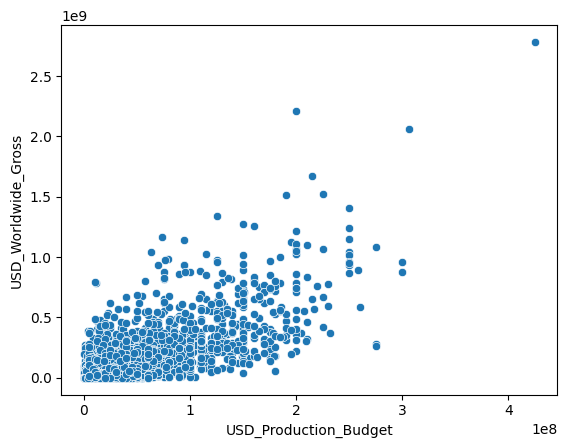

In [36]:
# Let's start with a basic scatter plot
sns.scatterplot(data_clean, x="USD_Production_Budget", y="USD_Worldwide_Gross")

c:\Users\CKL\.vscode\portfolio\film-budget\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\CKL\.vscode\portfolio\film-budget\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\CKL\.vscode\portfolio\film-budget\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\CKL\.vscode\portfolio\film-budget\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

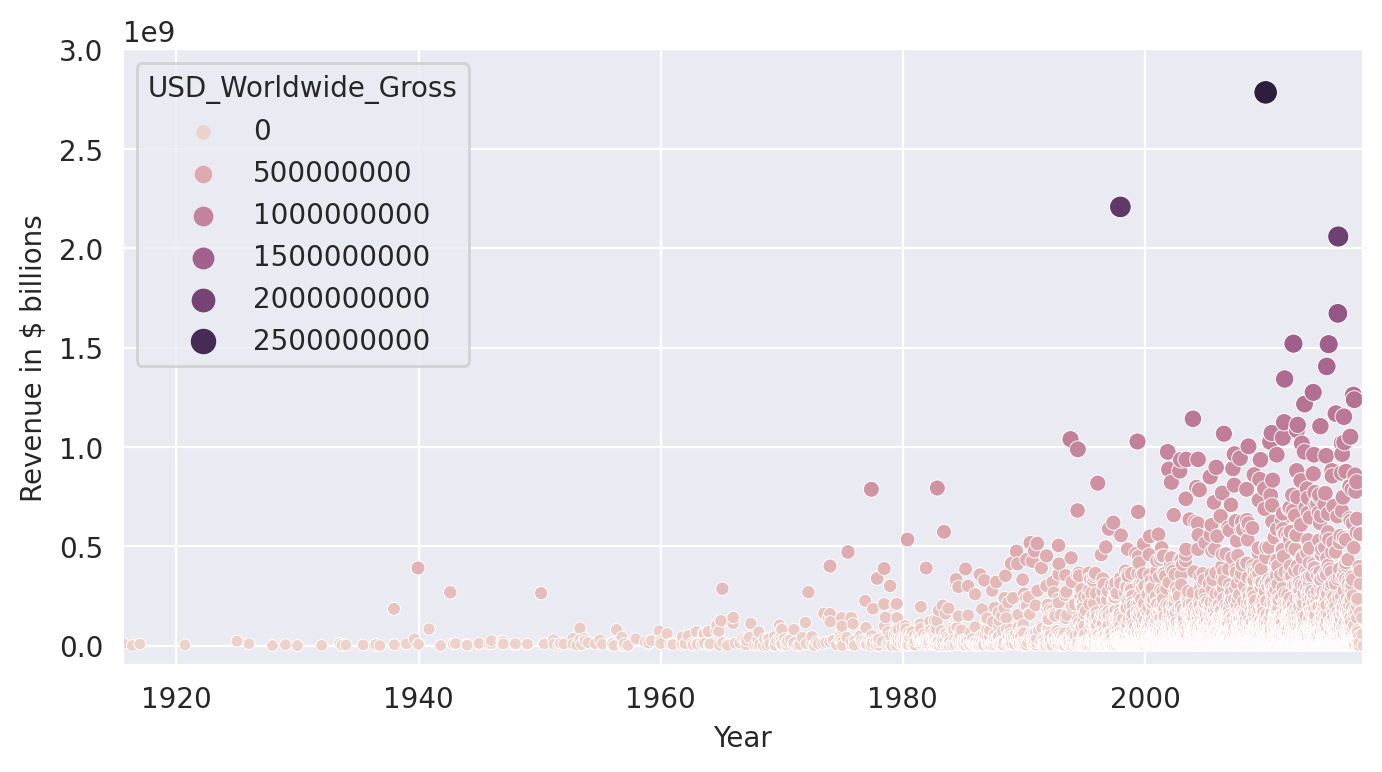

In [37]:
# Final plot
plt.figure(figsize=(8, 4), dpi=200)

with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(
        data=data_clean,
        x="Release_Date",
        y="USD_Worldwide_Gross",
        hue="USD_Worldwide_Gross",
        size="USD_Worldwide_Gross",
    )

    date_limits = (
        data_clean["Release_Date"].min(),
        data_clean["Release_Date"].max(),
    )

    ax.set(
        ylim=(-100_000_000, 3_000_000_000),
        xlim=date_limits,
        ylabel="Revenue in $ billions",
        xlabel="Year",
    )

# Converting Years to Decades

In [38]:
dt_years = pd.DatetimeIndex(data_clean["Release_Date"])
decades = (dt_years.year // 10) * 10
decades

Index([1910, 1910, 1910, 1920, 1920, 1920, 1920, 1920, 1930, 1930,
       ...
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010],
      dtype='int32', name='Release_Date', length=5384)

In [39]:
# Add new column- Decades
data_clean["Decade"] = decades
data_clean.sample(5)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
32,4515,1944-01-01,Bathing Beauty,"2,361,000.00","3,500,000.00","3,500,000.00",1940
3885,4671,2011-04-22,POM Wonderful Presents: The Greatest Movie Eve...,"1,800,000.00","783,733.00","638,476.00",2010
1220,864,1999-03-26,EDtv,"60,000,000.00","35,319,689.00","22,508,689.00",1990
424,3737,1985-11-10,Silver Bullet,"7,000,000.00","10,803,211.00","10,803,211.00",1980
966,1268,1997-04-18,McHale's Navy,"42,000,000.00","4,408,420.00","4,408,420.00",1990


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

Q: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [40]:
# `old_films` should include all the films before 1969 (up to and including 1969)
# `new_films` should include all the films from 1970 onwards
old_films = data_clean[data_clean["Decade"] <= 1960]
new_films = data_clean[data_clean["Decade"] > 1960]

In [41]:
# How many films were released prior to 1970?
len(old_films)

153

In [42]:
# What was the most expensive film made prior to 1970?
expensive_film = old_films.loc[
    old_films["USD_Production_Budget"].idxmax()
]  # data in Series (default)
display(expensive_film)

# In df row form (i prefer this aesthetically)
expensive_film_alt = expensive_film.to_frame().T
expensive_film_alt

Rank                                    1253
Release_Date             1963-12-06 00:00:00
Movie_Title                        Cleopatra
USD_Production_Budget          42,000,000.00
USD_Worldwide_Gross            71,000,000.00
USD_Domestic_Gross             57,000,000.00
Decade                                  1960
Name: 109, dtype: object

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
109,1253,1963-12-06 00:00:00,Cleopatra,"42,000,000.00","71,000,000.00","57,000,000.00",1960


# Seaborn Regression Plots

Q: Show the scatter plot and linear regression line against the `new_films`. 

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

<Axes: xlabel='USD_Production_Budget', ylabel='USD_Worldwide_Gross'>

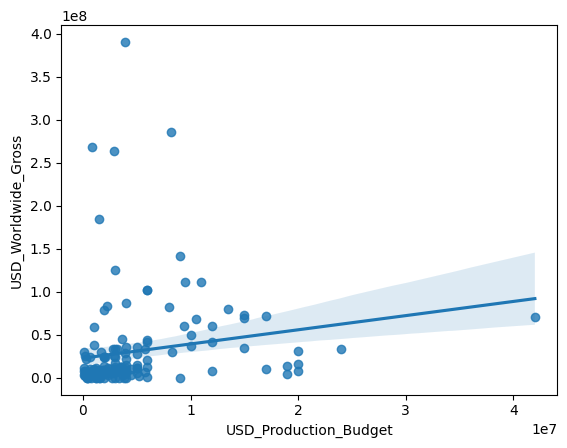

In [43]:
sns.regplot(
    old_films,
    x="USD_Production_Budget",
    y="USD_Worldwide_Gross",
)

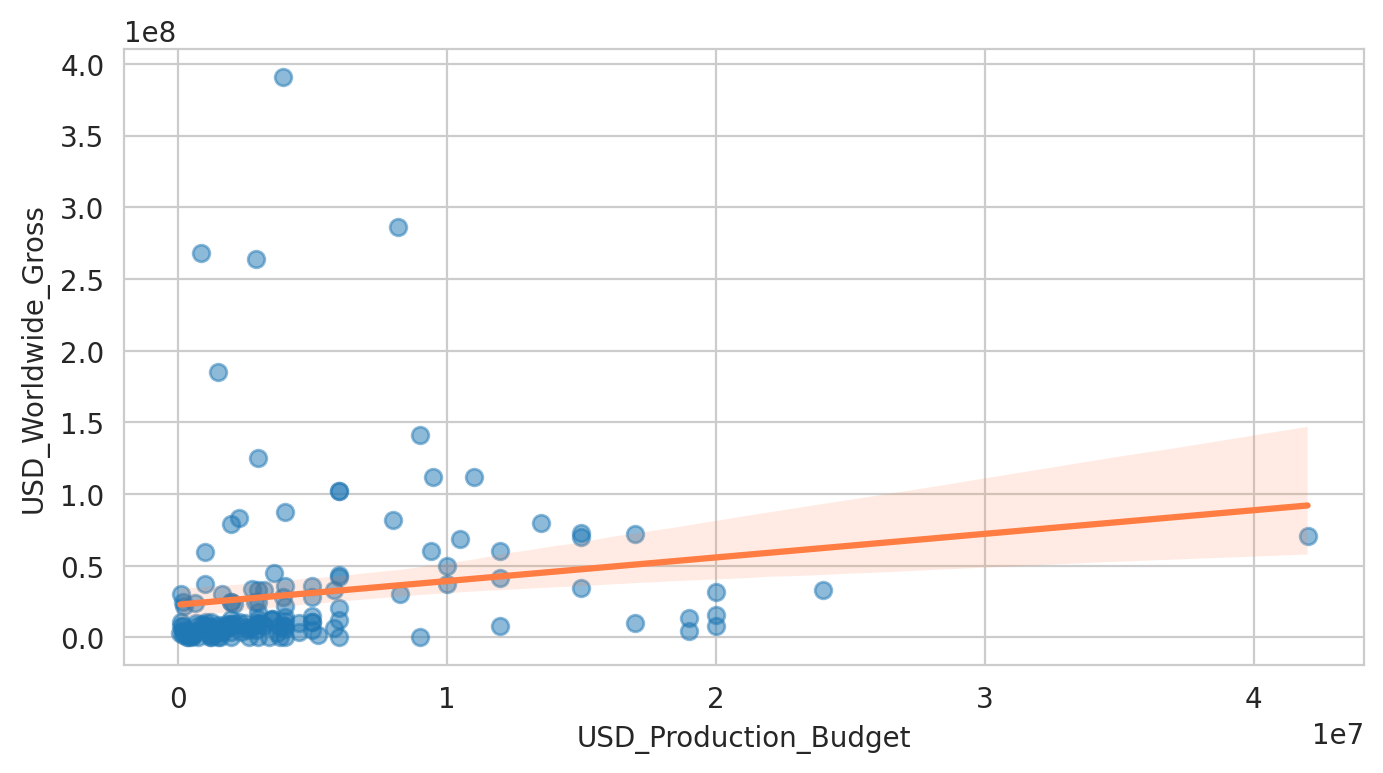

In [44]:
plt.figure(figsize=(8, 4), dpi=200)
with sns.axes_style("whitegrid"):
    sns.regplot(
        data=old_films,
        x="USD_Production_Budget",
        y="USD_Worldwide_Gross",
        scatter_kws={"alpha": 0.5},
        line_kws={"color": "#ff7c43"},
    )

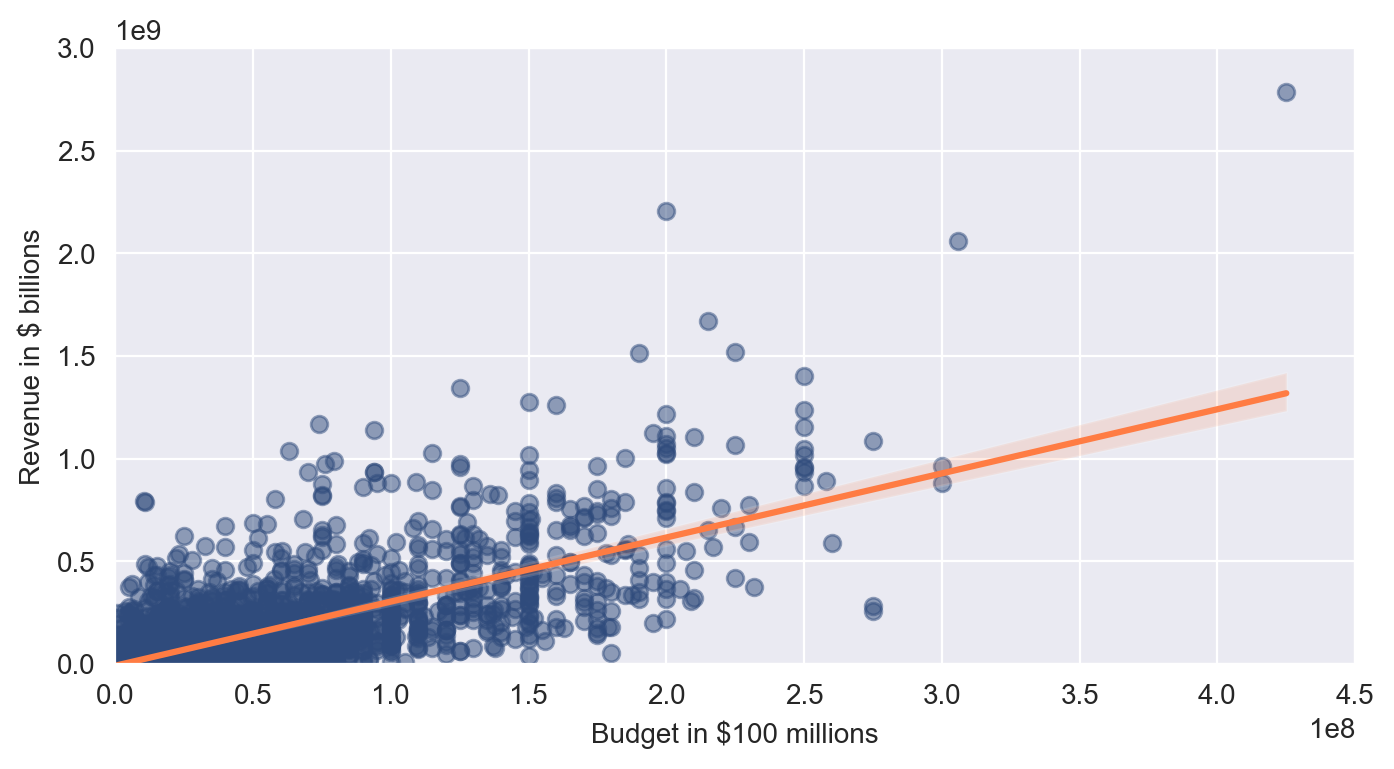

In [45]:
plt.figure(figsize=(8, 4), dpi=200)

with sns.axes_style("darkgrid"):
    ax = sns.regplot(
        new_films,
        x="USD_Production_Budget",
        y="USD_Worldwide_Gross",
        color="#2f4b7c",
        scatter_kws={"alpha": 0.5},
        line_kws={"color": "#ff7c43"},
    )

    ax.set(
        ylim=(0, 3_000_000_000),
        xlim=(0, 450_000_000),
        xlabel="Budget in $100 millions",
        ylabel="Revenue in $ billions",
    )

    plt.show()

## Interpretation
* **Do our data points for the new films align better or worse with the linear regression than for our older films?**  
Yes. The confidence interval is also higher.

* **Roughly how much would a film with a budget of $150 million make according to the regression line?**  
$500 million

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [46]:
# Regression object
regression = LinearRegression()

In [47]:
# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(new_films, columns=["USD_Production_Budget"])

# Response Variable or Target
y = pd.DataFrame(new_films, columns=["USD_Worldwide_Gross"])

In [48]:
regression.fit(X, y)

LinearRegression()

In [49]:
# Theta zero (y-intercept)
regression.intercept_

array([-8650768.00661042])

In [50]:
# Theta one (slope)
regression.coef_

array([[3.12259592]])

In [51]:
# R-squared (coefficient of determination)
regression.score(X, y)

0.5577032617720403

Q: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [52]:
regression_old = LinearRegression()
X = pd.DataFrame(old_films, columns=["USD_Production_Budget"])
y = pd.DataFrame(old_films, columns=["USD_Worldwide_Gross"])
regression_old.fit(X, y)

LinearRegression()

In [53]:
print(f"y-int: {regression_old.intercept_[0]}")
print(f"slope: {regression_old.coef_[0][0]}")
print(f"R2: {regression_old.score(X, y)}")

y-int: 22821538.635080386
slope: 1.6477131440107315
R2: 0.02937258620576877


# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Q**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [54]:
# Using the regression for old films:
y_int = regression_old.intercept_[0]
slope = regression_old.coef_[0][0]
expected_revenue = y_int + (slope * 350_000_000)
print(f"expected revenue: {expected_revenue:,.2f}")

expected revenue: 599,521,139.04


In [55]:
num = 100000000
print(f"{num:,}")

100,000,000
